# Assignment 2
Name: Xiyana Veroska Figuera Michal
 
Student number: 20225398



##  Excersice 2: Recycling Robot 

#### Part a: Solve the problem with optimization solver
I chose to solve the problem using Adam optimizer from torch

In [1]:
import torch
import torch.optim as optim

# Initialize tensors for the value functions
V_H = torch.tensor([0.0], requires_grad=True)
V_L = torch.tensor([0.0], requires_grad=True)

# Discount factor
gamma = 0.9

# Bellman loss function
def bellman_loss():

    # Bellman optimality equation for High state (H)
    V_H_search = 2 + gamma * (0.7 * V_H + 0.3 * V_L)
    V_H_wait = 1 + gamma * V_H
    loss_H = torch.max(V_H_search, V_H_wait) - V_H
    V_H_actions = {"Search": V_H_search.item(), "Wait": V_H_wait.item()}
    

    # Bellman optimality equation for Low state (L)
    V_L_search = 2 + gamma * (0.7 * V_L + 0.3 * (-10 + V_H))
    V_L_wait = 1 + gamma * V_L
    V_L_recharge = gamma * V_H
    loss_L = torch.max(V_L_search, torch.max(V_L_wait, V_L_recharge)) - V_L
    V_L_actions = {"Search": V_L_search.item(), "Wait": V_L_wait.item(), 
                   "Recharge": V_L_recharge.item()}

    # Combined loss
    loss = loss_H**2 + loss_L**2
    return loss, V_H_actions, V_L_actions

# Optimizer solver I chose to use
optimizer = optim.Adam([V_H, V_L], lr=0.01)

# Number of iterations
num_iterations = 10000

# Loop for optimizer
for i in range(num_iterations):

    # 
    optimizer.zero_grad()
    # Compute bellman loss
    loss, _, _ = bellman_loss()
    # C 
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}, V_H: {V_H.item()}, V_L: {V_L.item()}")

print(f"Optimal V*(H): {V_H.item():.4f}")
print(f"Optimal V*(L): {V_L.item():.4f}")

Iteration 0, Loss: 5.0, V_H: 0.009999998845160007, V_L: -0.009999998845160007
Iteration 100, Loss: 3.7622392177581787, V_H: 0.6659303903579712, V_L: -0.4428136944770813
Iteration 200, Loss: 3.625505208969116, V_H: 0.9249117374420166, V_L: -0.1858924925327301
Iteration 300, Loss: 3.4876277446746826, V_H: 1.1866484880447388, V_L: 0.07388167828321457
Iteration 400, Loss: 3.3590550422668457, V_H: 1.4496407508850098, V_L: 0.3329024612903595
Iteration 500, Loss: 3.2243969440460205, V_H: 1.7066408395767212, V_L: 0.5970708727836609
Iteration 600, Loss: 3.0998620986938477, V_H: 1.9676841497421265, V_L: 0.8550723791122437
Iteration 700, Loss: 2.974358320236206, V_H: 2.2248313426971436, V_L: 1.1150479316711426
Iteration 800, Loss: 2.8548789024353027, V_H: 2.481701374053955, V_L: 1.3730030059814453
Iteration 900, Loss: 2.7360916137695312, V_H: 2.739490270614624, V_L: 1.6276832818984985
Iteration 1000, Loss: 2.6243271827697754, V_H: 2.99630069732666, V_L: 1.881108045578003
Iteration 1100, Loss: 2.5

In [2]:
_, H_actions, L_actions = bellman_loss()

print("\nOptimal Policy (Optimization Solver):")
print("State: High =>  Action: ",max(H_actions, key=H_actions.get))
print("State: Low  =>  Action: ",max(L_actions, key=L_actions.get))



Optimal Policy (Optimization Solver):
State: High =>  Action:  Search
State: Low  =>  Action:  Recharge


#### Part b: Solve the problem with value iteration


In [3]:
import numpy as np

# Two states: High and Low
states = ['high', 'low']

# Actions: search, wait and recharge battery
actions = ['search', 'wait', 'recharge']

# Reward function for state and action 
rewards = {
    ('high', 'search'): 2,
    ('low', 'search'): 2,
    ('low', 'search_fail'): -10,
    ('high', 'wait'): 1,
    ('low', 'wait'): 1,
    ('low', 'recharge'): 0
}

# Transisition probability matrix
transition_prob = {
    ('high', 'search', 'high'): 0.7,
    ('high', 'search', 'low'): 0.3,
    ('low', 'search', 'low'): 0.7,
    ('low', 'search', 'rescued'): 0.3,
    ('high', 'wait', 'high'): 1.0,
    ('low', 'wait', 'low'): 1.0,
    ('low', 'recharge', 'high'): 1.0
}

# Discount factor
gamma = 0.9

# Value functions: initialize to 0
V = {'high': 0, 'low': 0}

# Threshold for convergence
theta = 1e-6

def get_value_function(state, action):
    if action == 'search':
        if state == 'high':
            
            # prob * (reward + gamma * V[next_state])
            return (transition_prob[(state, action, 'high')] * (rewards[(state, action)] + gamma * V['high']) +
                    transition_prob[(state, action, 'low')] * (rewards[(state, action)] + gamma * V['low']))
                
        elif state == 'low':
            # prob * (reward + gamma * V[next_state])
            return (transition_prob[(state, action, 'low')] * (rewards[(state, action)] + gamma * V['low']) +
                    transition_prob[(state, action, 'rescued')] * (rewards[(state, 'search_fail')] + gamma * 0))
        
    elif action == 'wait':
        return rewards[(state, action)] + gamma * V[state]
    elif action == 'recharge':
        if state == 'low':
            return rewards[(state, action)] + gamma * V['high']
    return 0

# Value iteration loop
iteration = 0
while True:
    
    delta = 0
    new_V = V.copy()
    for state in states:
        max_value = float('-inf')
        for action in actions:
            value = get_value_function(state, action)
            if value > max_value:
                max_value = value
        new_V[state] = max_value
        delta = max(delta, abs(new_V[state] - V[state]))
    V = new_V
    iteration += 1
    print(f"Iteration {iteration}: V(high) = {V['high']:.4f}, V(low) = {V['low']:.4f}")
    if delta < theta:
        break

print("\nFinal Value Function:")
print(f"V*(high) = {V['high']:.4f}")
print(f"V*(low) = {V['low']:.4f}")

Iteration 1: V(high) = 2.0000, V(low) = 1.0000
Iteration 2: V(high) = 3.5300, V(low) = 1.9000
Iteration 3: V(high) = 4.7369, V(low) = 3.1770
Iteration 4: V(high) = 5.8420, V(low) = 4.2632
Iteration 5: V(high) = 6.8316, V(low) = 5.2578
Iteration 6: V(high) = 7.7235, V(low) = 6.1484
Iteration 7: V(high) = 8.5259, V(low) = 6.9511
Iteration 8: V(high) = 9.2481, V(low) = 7.6733
Iteration 9: V(high) = 9.8981, V(low) = 8.3233
Iteration 10: V(high) = 10.4831, V(low) = 8.9083
Iteration 11: V(high) = 11.0096, V(low) = 9.4348
Iteration 12: V(high) = 11.4834, V(low) = 9.9086
Iteration 13: V(high) = 11.9099, V(low) = 10.3351
Iteration 14: V(high) = 12.2937, V(low) = 10.7189
Iteration 15: V(high) = 12.6391, V(low) = 11.0643
Iteration 16: V(high) = 12.9500, V(low) = 11.3752
Iteration 17: V(high) = 13.2298, V(low) = 11.6550
Iteration 18: V(high) = 13.4816, V(low) = 11.9068
Iteration 19: V(high) = 13.7083, V(low) = 12.1335
Iteration 20: V(high) = 13.9123, V(low) = 12.3375
Iteration 21: V(high) = 14.095

In [4]:
# Optimal policy extraction
policy = {}
for state in states:
    max_value = float('-inf')
    best_action = None
    for action in actions:
        if (state, action) in rewards:  
            value = get_value_function(state, action)
            if value > max_value:
                max_value = value
                best_action = action
    policy[state] = best_action

print("\nOptimal Policy (Value iteration):")
print("State: High =>  Action: ",policy['high'])
print("State: Low  =>  Action: ",policy['low'])


Optimal Policy (Value iteration):
State: High =>  Action:  search
State: Low  =>  Action:  recharge


## Excersice  6 (13.2)

#### Baird's counter example
Import necessary libraries

In [7]:
import gym
import gym.utils.seeding
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Them we create an environment with gym (for convinience)

In [8]:
class My_environment(gym.Env):
    
    # Observation space: We have seven states (0~6) 
    observation_space = gym.spaces.Discrete(7)
    # We have two actions which are dashed line action = 0 and solid line action = 1.
    action_space = gym.spaces.Discrete(2)
    # Our rewards are always zero
    reward_range = (0, 0)

    def __init__(self):
        self.seed()

    def step(self, action): 
        
        state = None
        # Dashed line action
        if action == 1:  
            # Create a new Discrete space with range [0, 5]
            # This is used only to pick up an action from 0 to 5
            sub_observation_space = gym.spaces.Discrete(6)  
            state = sub_observation_space.sample()
            
        # Solid line action
        if action == 0: 
            state = 6

        return state, 0.0, False, {}  # ver como cambiar cuantas cosas devuelve

    def reset(self):
        
        state  =  self.observation_space.sample()
        return state

    def seed(self, seed=None):
        _, seed = gym.utils.seeding.np_random(seed)
        return [seed]


gym.envs.registration.register(
    id='Bairds-v0',
    entry_point=lambda: My_environment(),
    nondeterministic=True,
)

/Users/xiyanafiguera/miniconda3/envs/tor/lib/python3.11/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Bairds-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Then, a One-Step semi-gradient Q Learning class

In [9]:
class OneStepSemiGradientQLearning:
    def __init__(self, env, gamma=0.99, alpha=0.05): 
        self.env = env
        self.gamma = gamma
        self.alpha = alpha

        # Linear function approximation for state-value function
        self.lin_approx_4_state_val_func = torch.tensor(
            [  # w1,w2,w3,w4,w5,w6,w7,w8
                [2, 0, 0, 0, 0, 0, 0, 1],  # V(1)
                [0, 2, 0, 0, 0, 0, 0, 1],  # V(2)
                [0, 0, 2, 0, 0, 0, 0, 1],  # V(3)
                [0, 0, 0, 2, 0, 0, 0, 1],  # V(4)
                [0, 0, 0, 0, 2, 0, 0, 1],  # V(5)
                [0, 0, 0, 0, 0, 2, 0, 1],  # V(6)
                [0, 0, 0, 0, 0, 0, 1, 2],  # V(7)
            ],
            dtype=torch.float,
            requires_grad=False
        )

        # Initial weights (from figure 11.2 Sutton's rl book)
        self.tensors_w = torch.tensor(
            [
                [1, 1],
                [1, 1],
                [1, 1],
                [1, 1],
                [1, 1],
                [1, 1],
                [10, 10],
                [1, 1],
            ],
            dtype=torch.float,
            requires_grad=True
        )

    # Function to get the q function value
    def get_q(self, state, action):
        return torch.matmul(self.lin_approx_4_state_val_func[state], self.tensors_w[:, action]) 

    # Function to update the q function value
    def update_q(self, state, action, reward, next_state):
        q_val = self.get_q(state, action)
        q_target = reward + self.gamma * torch.max(self.get_q(next_state, 0), self.get_q(next_state, 1))
        delta = q_target - q_val

        q_val.backward()

        # Semi-gradient 
        with torch.no_grad():
            self.tensors_w += self.alpha * delta * self.tensors_w.grad
            self.tensors_w.grad.zero_()

    
    def behavior_policy(self):
        # Action taken by behavior policy
        return 0 if np.random.rand() < (1 / self.env.observation_space.n) else 1

    def train(self, n_steps):
        # Set one step for our one-step semi-gradient Q learning
        step = 1
        done = False
        history0, history1 = [], []
        state = self.env.reset()

        while not done and step < n_steps:
            action = self.behavior_policy()
            next_state, reward, done, info = self.env.step(action)
            self.update_q(state, action, reward, next_state)

            state = next_state
            step += 1

            history0.append(self.tensors_w[:, 0].tolist())
            history1.append(self.tensors_w[:, 1].tolist())

        return history0, history1


env =  gym.make('Bairds-v0')  
q_learning = OneStepSemiGradientQLearning(env)
history0, history1 = q_learning.train(n_steps=1000)

/Users/xiyanafiguera/miniconda3/envs/tor/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/xiyanafiguera/miniconda3/envs/tor/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/xiyanafiguera/miniconda3/envs/tor/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(
/Users/xiyanafiguera/miniconda3/envs/tor/lib/python3.11/site-packag

Plot the figure with the history of weigths to check if they diverge

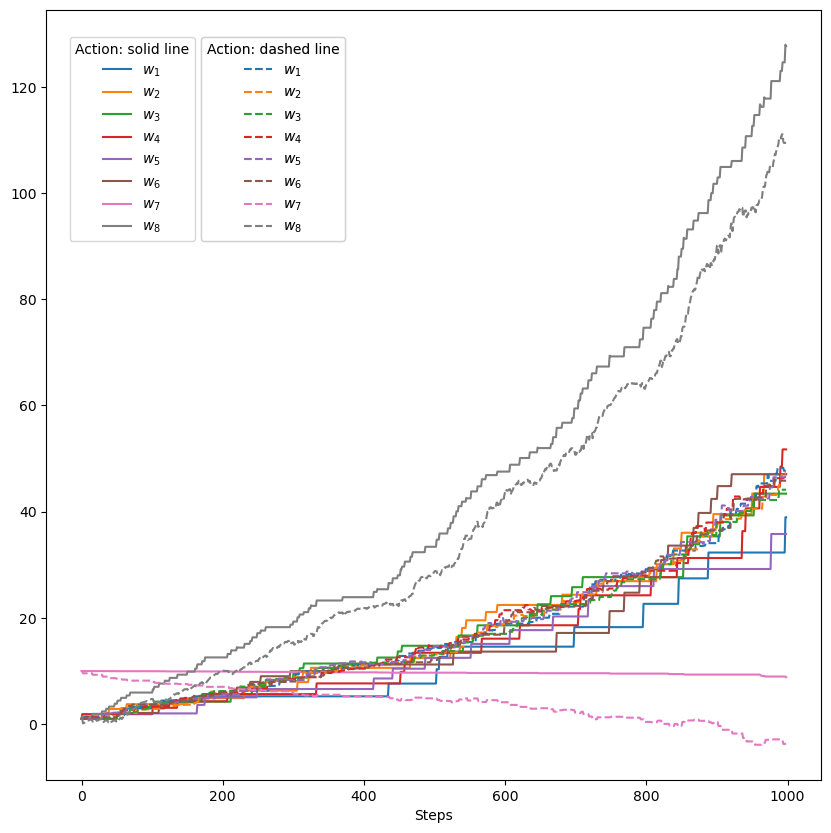

In [16]:
fig, ax = plt.subplots(figsize=[10, 10])
labels = [f"$w_{i+1}$" for i in range(8)]

solid_lines = []
colors = plt.cm.tab10.colors  
for i in range(8):
    line, = ax.plot([row[i] for row in history0], linestyle='-', label=labels[i], color=colors[i % 10])
    solid_lines.append(line)

dashed_lines = []
for i in range(8):
    line, = ax.plot([row[i] for row in history1], linestyle='--', label=labels[i], color=colors[i % 10])
    dashed_lines.append(line)

solid_legend = ax.legend(handles=solid_lines, title='Action: solid line', loc=[0.03, 0.7])
ax.add_artist(solid_legend)  
dashed_legend = ax.legend(handles=dashed_lines, title='Action: dashed line', loc=[0.20, 0.7])
ax.add_artist(dashed_legend) 
ax.set_xlabel("Steps")
plt.show()
